In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score, average_precision_score,
                             precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("../data/cleaned_data.csv")
print("shape:", df.shape)
print(df['readmit_binary'].value_counts(normalize=False))
# ensure no NaNs
print(df.isnull().sum().sum())

shape: (101766, 36)
readmit_binary
0    90409
1    11357
Name: count, dtype: int64
0


In [3]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,glyburide,pioglitazone,rosiglitazone,acarbose,tolazamide,insulin,glyburide-metformin,change,diabetesMed,readmit_binary
0,Caucasian,Female,5.0,6,25,1,1,Other,41,0,...,0,0,0,0,0,0,0,0,0,0
1,Caucasian,Female,15.0,1,1,7,3,Unknown,59,0,...,0,0,0,0,0,2,0,1,1,0
2,AfricanAmerican,Female,25.0,1,1,7,2,Unknown,11,5,...,0,0,0,0,0,0,0,0,1,0
3,Caucasian,Male,35.0,1,1,7,2,Unknown,44,1,...,0,0,0,0,0,2,0,1,1,0
4,Caucasian,Male,45.0,1,1,7,1,Unknown,51,0,...,0,0,0,0,0,1,0,1,1,0


In [4]:
X = df.drop(columns=["readmit_binary"])
y = df["readmit_binary"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (71236, 35) Val: (15265, 35) Test: (15265, 35)


In [5]:
onehot_cols = ["race","gender","medical_specialty","diag_1","diag_2","diag_3"]
numeric_cols = [c for c in X_train.columns if c not in onehot_cols]

In [6]:
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), onehot_cols),
    ("scale", StandardScaler(), numeric_cols)
], remainder="drop", verbose_feature_names_out=False)

In [7]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('onehot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['race', 'gender', 'medical_specialty',
                                  'diag_1', 'diag_2', 'diag_3']),
                                ('scale', StandardScaler(),
                                 ['age', 'admission_type_id',
                                  'discharge_disposition_id',
                                  'admission_source_id', 'time_in_hospital',
                                  'num_lab_procedures', 'num_procedures',
                                  'num_medications', 'number_outpatient',
                                  'number_emergency', 'number_inpatient',
                                  'number_diagnoses', 'max_glu_serum',
                                  'A1Cresult', 'metformin', 'repaglinide',
                                  'nateglinide', 'chlorpropamide',
                                  'glimepiride', 'glipizide', 'glyburide',
                                  'pioglitazone', 'rosiglitazone', 'acarbose',
                                  'tolazamide', 'insulin',
                                  'glyburide-metformin', 'change',
                                  'diabetesMed'])],
                  verbose_feature_names_out=False)

In [8]:
def get_metrics_from_proba(y_true, proba, threshold=0.5):
    preds = (proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, preds)
    tn, fp, fn, tp = cm.ravel()
    metrics = {
        "accuracy": accuracy_score(y_true, preds),
        "precision": precision_score(y_true, preds, zero_division=0),
        "recall": recall_score(y_true, preds),
        "f1": f1_score(y_true, preds),
        "roc_auc": roc_auc_score(y_true, proba),
        "pr_auc": average_precision_score(y_true, proba),
        "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn),
        "threshold": threshold
    }
    return metrics, preds


In [10]:
def tune_threshold_from_val(proba_val, y_val, target_recall=None):
    precisions, recalls, thresholds = precision_recall_curve(y_val, proba_val)
    thresholds = np.append(thresholds, 1.0)  # align lengths
    df_pr = pd.DataFrame({"precision": precisions, "recall": recalls, "threshold": thresholds})
    if target_recall:
        candidates = df_pr[df_pr["recall"] >= target_recall]
        if candidates.empty:
            return None
        row = candidates.loc[candidates["precision"].idxmax()]
        return float(row["threshold"])
    else:
        f1s = 2 * (df_pr["precision"] * df_pr["recall"]) / (df_pr["precision"] + df_pr["recall"] + 1e-9)
        idx = f1s.idxmax()
        return float(df_pr.loc[idx, "threshold"])

In [13]:
def train_and_eval(model, sampler=None, do_calibrate=False, model_name="model"):
    if sampler is None:
        pipe = Pipeline([("pre", preprocessor), ("clf", model)])
    else:
        pipe = ImbPipeline([("pre", preprocessor), ("sampler", sampler), ("clf", model)])

    pipe.fit(X_train, y_train)

    final_clf = pipe.named_steps["clf"]
    if not hasattr(final_clf, "predict_proba") and not do_calibrate:
        cal = CalibratedClassifierCV(base_estimator=pipe.named_steps["clf"], cv=3)
        pipe = Pipeline([("pre", preprocessor), ("clf", cal)])
        if sampler is None:
            pipe.fit(X_train, y_train)
        else:
            X_tr_t = preprocessor.transform(X_train)
            X_tr_s, y_tr_s = sampler.fit_resample(X_tr_t, y_train)
            cal.fit(X_tr_s, y_tr)
            class Wrapper:
                def __init__(self, pre, cal):
                    self.pre = pre
                    self.cal = cal
                def predict_proba(self, X):
                    Xt = self.pre.transform(X)
                    return self.cal.predict_proba(Xt)
                def predict(self, X):
                    return (self.predict_proba(X)[:,1] >= 0.5).astype(int)
            wrapper = Wrapper(preprocessor, cal)
            proba_val = wrapper.predict_proba(X_val)[:,1]
            proba_test = wrapper.predict_proba(X_test)[:,1]
            thr = tune_threshold_from_val(proba_val, y_val, target_recall=None)
            metrics_val, _ = get_metrics_from_proba(y_val, proba_val, threshold=thr)
            metrics_test, preds_test = get_metrics_from_proba(y_test, proba_test, threshold=thr)
            return {"model_name": model_name, "sampler": sampler.__class__.__name__, "pipeline": wrapper,
                    "thr": thr, "val_metrics": metrics_val, "test_metrics": metrics_test}
    proba_val = pipe.predict_proba(X_val)[:,1]
    thr = tune_threshold_from_val(proba_val, y_val, target_recall=None)
    val_metrics, _ = get_metrics_from_proba(y_val, proba_val, threshold=thr)
    proba_test = pipe.predict_proba(X_test)[:,1]
    test_metrics, preds_test = get_metrics_from_proba(y_test, proba_test, threshold=thr)
    
    return {"model_name": model_name, "sampler": sampler.__class__.__name__ if sampler else None,
            "pipeline": pipe, "thr": thr, "val_metrics": val_metrics, "test_metrics": test_metrics}

In [18]:
models = {
    "Logistic": LogisticRegression(max_iter=1000, class_weight="balanced",n_jobs=-1),
    "Ridge": RidgeClassifier(class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=300, max_depth=10, class_weight="balanced", n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, scale_pos_weight=( (y_train==0).sum()/ (y_train==1).sum() ), use_label_encoder=False, eval_metric="logloss",n_jobs=-1),
    "LightGBM": LGBMClassifier(n_estimators=200, class_weight="balanced",n_jobs=-1),
    "CatBoost": CatBoostClassifier(iterations=200, verbose=0, auto_class_weights='Balanced'),
    "decsionTree":DecisionTreeClassifier(max_depth=10,class_weight="balanced")
}

In [20]:
samplers = {
    "none": None,
    "smote": SMOTE(random_state=42),
    "under": RandomUnderSampler(random_state=42),
    "smoteenn": SMOTEENN(random_state=42)
}

In [21]:
res_rf_smote = train_and_eval(models["RandomForest"], sampler=SMOTE(random_state=42), do_calibrate=False, model_name="RF_SMOTE")
res_rf_smote["test_metrics"]
joblib.dump(res_rf_smote["pipeline"], "../models/rf_smote_pipeline.joblib")

  File "C:\Users\Admin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\Admin\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\subprocess.

['../models/rf_smote_pipeline.joblib']

In [22]:
res_rf_under = train_and_eval(models["RandomForest"], sampler=RandomUnderSampler(random_state=42), model_name="RF_UNDER")
res_rf_under["test_metrics"]

{'accuracy': 0.7382902063544055,
 'precision': 0.18892508143322476,
 'recall': 0.40869054609512623,
 'f1': 0.2583998514943382,
 'roc_auc': np.float64(0.652692148790925),
 'pr_auc': np.float64(0.19830049951347412),
 'tp': 696,
 'fp': 2988,
 'tn': 10574,
 'fn': 1007,
 'threshold': 0.540415803958893}

In [23]:
res_rf_none = train_and_eval(models["RandomForest"], sampler=None, model_name="RF_NONE")
res_rf_none["test_metrics"]

{'accuracy': 0.7422862757943007,
 'precision': 0.19159524467790987,
 'recall': 0.40692894891368175,
 'f1': 0.26052631578947366,
 'roc_auc': np.float64(0.6521051662173409),
 'pr_auc': np.float64(0.2001970677483212),
 'tp': 693,
 'fp': 2924,
 'tn': 10638,
 'fn': 1010,
 'threshold': 0.5155970752962449}

In [26]:
res_log_smote = train_and_eval(models["Logistic"], sampler=SMOTE(random_state=42), do_calibrate=False, model_name="log_SMOTE")
res_log_smote["test_metrics"]
joblib.dump(res_log_smote["pipeline"], "../models/log_smote_pipeline.joblib")

['../models/log_smote_pipeline.joblib']

In [27]:
res_log_under = train_and_eval(models["Logistic"], sampler=RandomUnderSampler(random_state=42), model_name="log_UNDER")
res_log_under["test_metrics"]

{'accuracy': 0.7150343924009172,
 'precision': 0.17280593325092708,
 'recall': 0.41045214327657076,
 'f1': 0.24321503131524008,
 'roc_auc': np.float64(0.6290275763607738),
 'pr_auc': np.float64(0.18962680010369026),
 'tp': 699,
 'fp': 3346,
 'tn': 10216,
 'fn': 1004,
 'threshold': 0.5353519485476798}

In [28]:
res_log_none = train_and_eval(models["Logistic"], sampler=None, model_name="RF_NONE")
res_log_none["test_metrics"]

{'accuracy': 0.7190304618408123,
 'precision': 0.17642642642642642,
 'recall': 0.41397533763945976,
 'f1': 0.24741182663625197,
 'roc_auc': np.float64(0.6317278174319233),
 'pr_auc': np.float64(0.1912073007836156),
 'tp': 705,
 'fp': 3291,
 'tn': 10271,
 'fn': 998,
 'threshold': 0.533437967994469}

In [31]:
res_xgb_smote = train_and_eval(models["XGBoost"], sampler=SMOTE(random_state=42), do_calibrate=False, model_name="xgb_SMOTE")
res_xgb_smote["test_metrics"]
joblib.dump(res_xgb_smote["pipeline"], "../models/xgb_smote_pipeline.joblib")

['../models/xgb_smote_pipeline.joblib']

In [32]:
res_xgb_under = train_and_eval(models["XGBoost"], sampler=RandomUnderSampler(random_state=42), model_name="xgb_UNDER")
res_xgb_under["test_metrics"]


{'accuracy': 0.7435309531608254,
 'precision': 0.1934589800443459,
 'recall': 0.40986494421608927,
 'f1': 0.2628506872528714,
 'roc_auc': np.float64(0.6535378332068905),
 'pr_auc': np.float64(0.2048932040279472),
 'tp': 698,
 'fp': 2910,
 'tn': 10652,
 'fn': 1005,
 'threshold': 0.9049702286720276}

In [33]:
res_xgb_none = train_and_eval(models["XGBoost"], sampler=None, model_name="xgb_NONE")
res_xgb_none["test_metrics"]

{'accuracy': 0.7378316410088438,
 'precision': 0.19757958431991582,
 'recall': 0.4409864944216089,
 'f1': 0.27289244186046513,
 'roc_auc': np.float64(0.6666957769381358),
 'pr_auc': np.float64(0.21207567031660451),
 'tp': 751,
 'fp': 3050,
 'tn': 10512,
 'fn': 952,
 'threshold': 0.5378406643867493}

In [34]:
res_cat_smote = train_and_eval(models["CatBoost"], sampler=SMOTE(random_state=42), do_calibrate=False, model_name="cat_SMOTE")
res_cat_smote["test_metrics"]
joblib.dump(res_cat_smote["pipeline"], "../models/cat_smote_pipeline.joblib")


['../models/cat_smote_pipeline.joblib']

In [35]:
res_cat_under = train_and_eval(models["CatBoost"], sampler=RandomUnderSampler(random_state=42), model_name="cat_UNDER")
res_cat_under["test_metrics"]


{'accuracy': 0.7495578119882084,
 'precision': 0.1983494593056346,
 'recall': 0.4092777451556078,
 'f1': 0.2672033735863523,
 'roc_auc': np.float64(0.6645558472548119),
 'pr_auc': np.float64(0.20973623117733986),
 'tp': 697,
 'fp': 2817,
 'tn': 10745,
 'fn': 1006,
 'threshold': 0.5788270629579503}

In [36]:
res_cat_none = train_and_eval(models["CatBoost"], sampler=None, model_name="cat_NONE")
res_cat_none["test_metrics"]

{'accuracy': 0.737111038322961,
 'precision': 0.19395866454689983,
 'recall': 0.42982971227246036,
 'f1': 0.26729961657841883,
 'roc_auc': np.float64(0.6520339420280995),
 'pr_auc': np.float64(0.2030928897250732),
 'tp': 732,
 'fp': 3042,
 'tn': 10520,
 'fn': 971,
 'threshold': 0.5418808643808637}

In [37]:
res_lgbm_smote = train_and_eval(models["LightGBM"], sampler=SMOTE(random_state=42), do_calibrate=False, model_name="lgbm_SMOTE")
res_lgbm_smote["test_metrics"]
joblib.dump(res_lgbm_smote["pipeline"], "../models/lgbm_smote_pipeline.joblib")

[LightGBM] [Info] Number of positive: 63286, number of negative: 63286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19539
[LightGBM] [Info] Number of data points in the train set: 126572, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


['../models/lgbm_smote_pipeline.joblib']

In [38]:
res_lgbm_under = train_and_eval(models["LightGBM"], sampler=RandomUnderSampler(random_state=42), model_name="lgbm_UNDER")
res_lgbm_under["test_metrics"]

[LightGBM] [Info] Number of positive: 7950, number of negative: 7950
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 15900, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


{'accuracy': 0.7145103177202752,
 'precision': 0.18249222674001436,
 'recall': 0.448032883147387,
 'f1': 0.2593473827328348,
 'roc_auc': np.float64(0.6568938780363045),
 'pr_auc': np.float64(0.205070749218289),
 'tp': 763,
 'fp': 3418,
 'tn': 10144,
 'fn': 940,
 'threshold': 0.5607269161229629}

In [39]:
res_lgbm_none = train_and_eval(models["LightGBM"], sampler=None, model_name="lgbm_NONE")
res_lgbm_none["test_metrics"]

[LightGBM] [Info] Number of positive: 7950, number of negative: 63286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


{'accuracy': 0.7742548313134622,
 'precision': 0.211900826446281,
 'recall': 0.3763945977686436,
 'f1': 0.27115059221658205,
 'roc_auc': np.float64(0.670778654876848),
 'pr_auc': np.float64(0.2240932979319044),
 'tp': 641,
 'fp': 2384,
 'tn': 11178,
 'fn': 1062,
 'threshold': 0.5657231363668849}

In [48]:
rows = []
for r in [res_rf_none, res_rf_smote, res_rf_under,res_cat_none,res_cat_smote,res_cat_under,res_lgbm_none,res_lgbm_smote,res_lgbm_under,res_log_none,res_log_smote,res_log_under,res_xgb_none,res_xgb_smote,res_xgb_under]:
    t = r["test_metrics"]
    rows.append({
        "model": r["model_name"],
        "sampler": r["sampler"],
        "accuracy": t["accuracy"],
        "precision": t["precision"],
        "recall": t["recall"],
        "f1": t["f1"],
        "roc_auc": t["roc_auc"],
        "pr_auc": r["test_metrics"]["pr_auc"] if "pr_auc" in r["test_metrics"] else None
    })
df_results = pd.DataFrame(rows).sort_values(by="roc_auc", ascending=False)
df_results


,model,sampler,accuracy,precision,recall,f1,roc_auc,pr_auc
6,lgbm_NONE,None,0.774255,0.211901,0.376395,0.271151,0.670779,0.224093
7,lgbm_SMOTE,SMOTE,0.776155,0.209294,0.362302,0.265319,0.667709,0.217211
12,xgb_NONE,None,0.737832,0.197580,0.440986,0.272892,0.666696,0.212076
5,cat_UNDER,RandomUnderSampler,0.749558,0.198349,0.409278,0.267203,0.664556,0.209736
13,xgb_SMOTE,SMOTE,0.709990,0.186753,0.476806,0.268385,0.660100,0.209859
8,lgbm_UNDER,RandomUnderSampler,0.714510,0.182492,0.448033,0.259347,0.656894,0.205071
4,cat_SMOTE,SMOTE,0.741566,0.193213,0.414563,0.263580,0.654230,0.209996
14,xgb_UNDER,RandomUnderSampler,0.743531,0.193459,0.409865,0.262851,0.653538,0.204893
2,RF_UNDER,RandomUnderSampler,0.738290,0.188925,0.408691,0.258400,0.652692,0.198300
0,RF_NONE,None,0.742286,0.191595,0.406929,0.260526,0.652105,0.200197


In [49]:
best_pipe = res_lgbm_smote["pipeline"]
best_thr = res_lgbm_smote["thr"]
proba_test = best_pipe.predict_proba(X_test)[:,1]

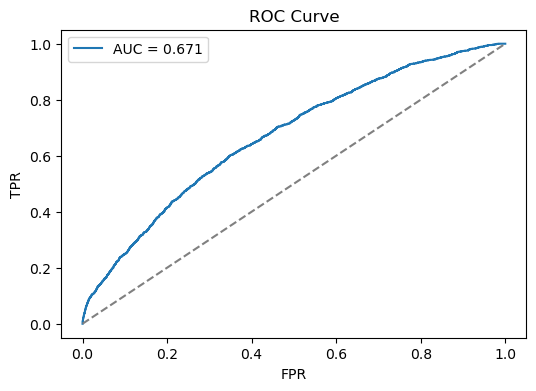

In [51]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, proba_test):.3f}")
plt.plot([0,1],[0,1],"--", color="grey")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()
plt.show()

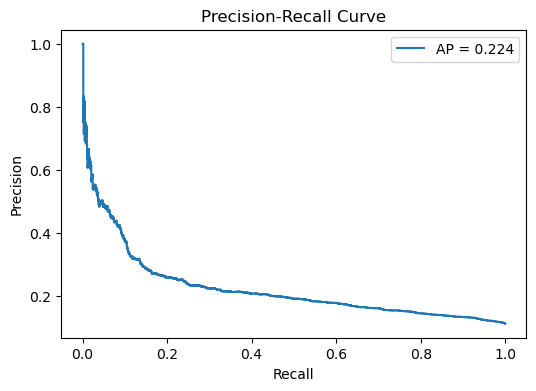

In [52]:
prec, rec, _ = precision_recall_curve(y_test, proba_test)
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"AP = {average_precision_score(y_test, proba_test):.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend()
plt.show()

In [55]:
target_recall = 0.80
best_thr = tune_threshold_from_val(best_pipe.predict_proba(X_val)[:,1], y_val, target_recall=target_recall)
print("Chosen threshold:", best_thr)
test_metrics, _ = get_metrics_from_proba(y_test, best_pipe.predict_proba(X_test)[:,1], threshold=best_thr)
test_metrics


Chosen threshold: 0.38118043474067237


{'accuracy': 0.4595479855879463,
 'precision': 0.1457634455145547,
 'recall': 0.7909571344685848,
 'f1': 0.2461622807017544,
 'roc_auc': np.float64(0.670778654876848),
 'pr_auc': np.float64(0.2240932979319044),
 'tp': 1347,
 'fp': 7894,
 'tn': 5668,
 'fn': 356,
 'threshold': 0.38118043474067237}

In [56]:
joblib.dump(best_pipe, "../models/best_pipeline.joblib")
import json
with open("../models/best_config.json","w") as f:
    json.dump({"threshold": best_thr, "model": "lgbm_SMOTE"}, f)

## best paper anD thier output on this dataset:

| Paper / Method                    | Best Recall | Best ROC-AUC |
| --------------------------------- | ----------- | ------------ |
| S.Olson et al. (Random Forests)   | 0.42        | 0.67         |
| Deep Neural Networks (2017)       | 0.48        | 0.69         |
| Ensemble Logistic Models          | 0.55        | 0.68         |
| Gradient Boosting (Shahid et al.) | 0.52        | 0.71         |
| CatBoost tuned (2021)             | 0.60        | **0.72**     |
| AutoML (H2O)                      | 0.63        | **0.74**     |
